### Pipeline completo de pré-processamento para Credit Card Fraud Detection (Kaggle)
### Etapas: visualização, nulos, duplicatas, inconsistências, outliers, escalonamento, correlação,
### Balanceamento e divisão estratificada

Imports


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# -----------------------------------------------------------------------------
# 0) Configurações
# -----------------------------------------------------------------------------
RANDOM_STATE = 42
TEST_SIZE = 0.2
CSV_PATH = "creditcard.csv"

1) Visualização inicial

Dimensões: (284807, 31)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 no

C:\Users\mathe\AppData\Local\Temp\ipykernel_4832\1269371234.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Class", data=df, palette="Set2")


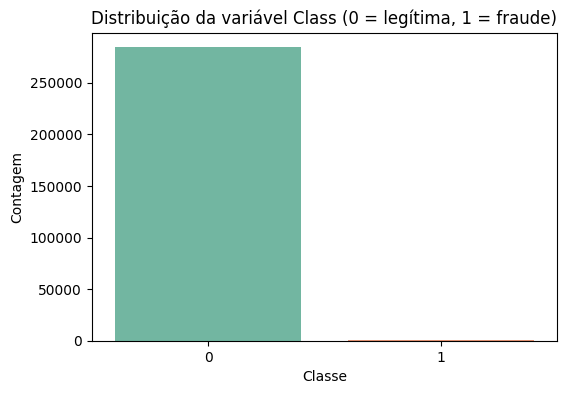


Proporção das classes:
Class
0    0.998273
1    0.001727
Name: proporção, dtype: float64


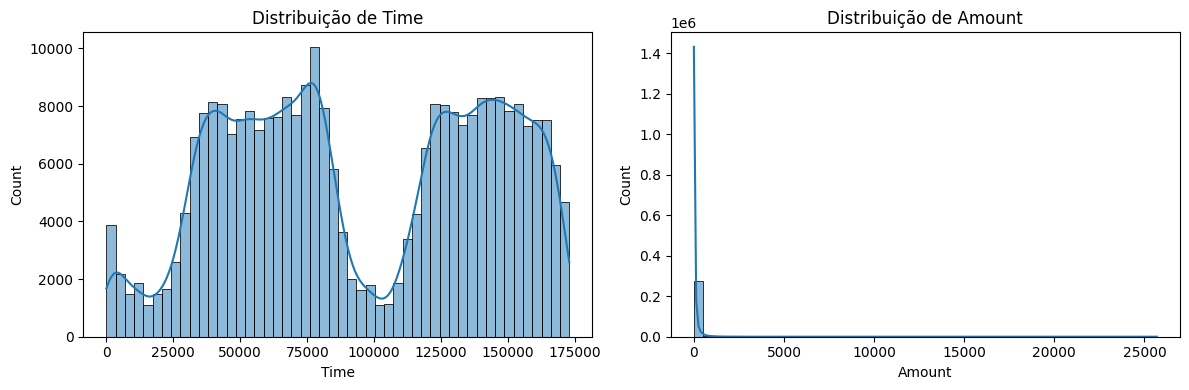

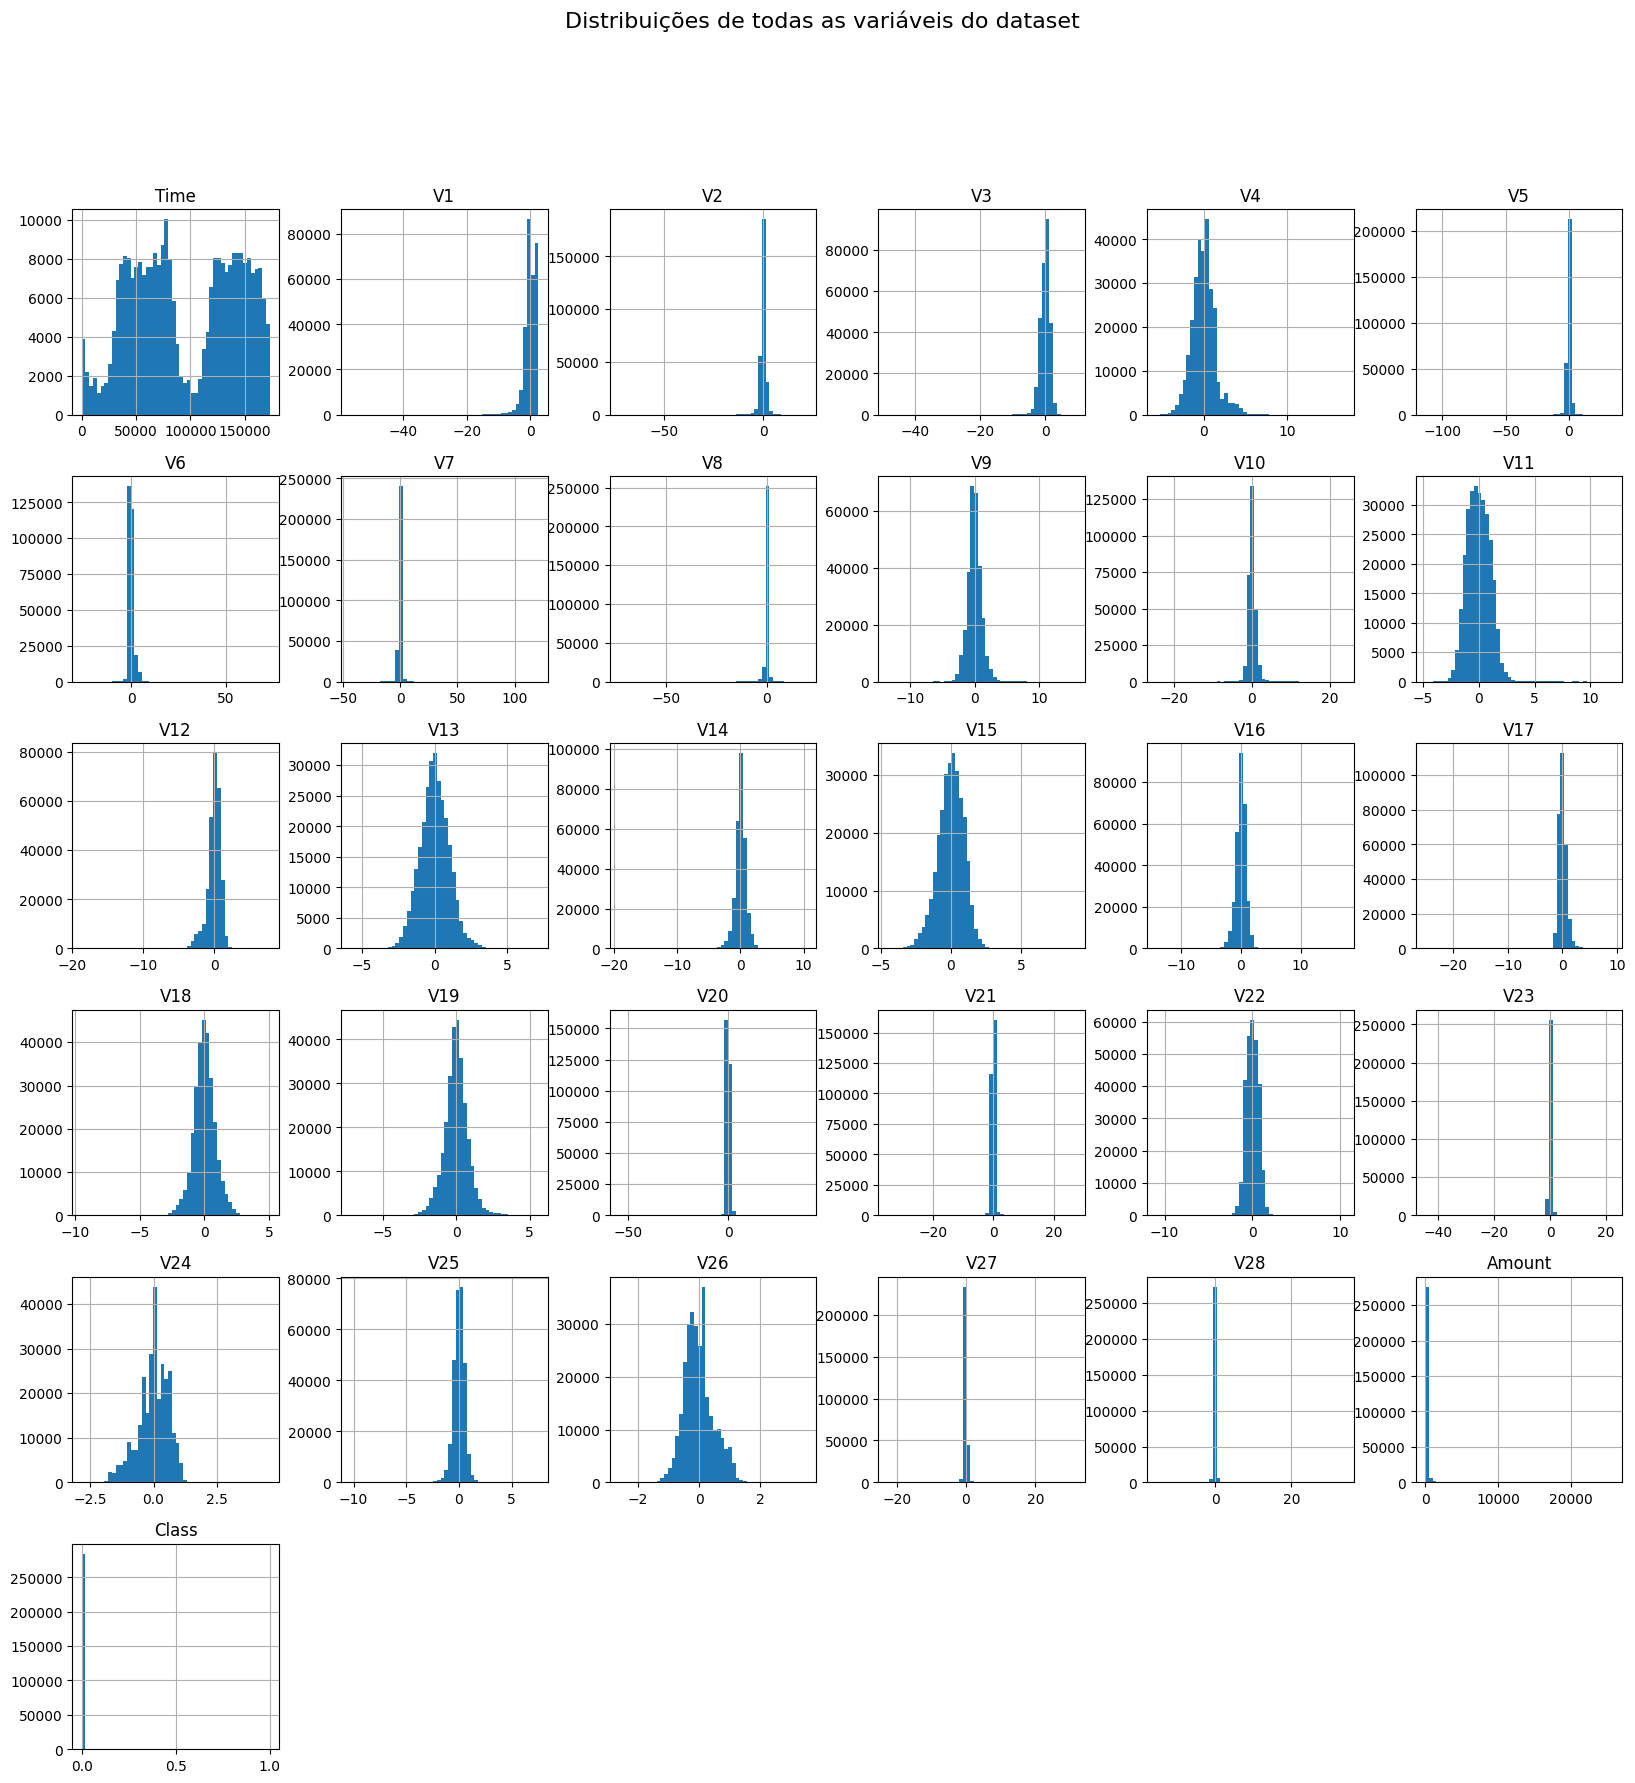

In [2]:
# carregamento da base de dados
df = pd.read_csv("creditcard.csv")

print("Dimensões:", df.shape)
print("\nInfo:")
print(df.info())
print("\nDescrição estatística (numéricas):")
print(df.describe().T)

df

# distribuição da Class (variável alvo)
plt.figure(figsize=(6,4))
sns.countplot(x="Class", data=df, palette="Set2")
plt.title("Distribuição da variável Class (0 = legítima, 1 = fraude)")
plt.xlabel("Classe")
plt.ylabel("Contagem")
plt.show()

print("\nProporção das classes:")
print(df["Class"].value_counts(normalize=True).rename("proporção"))


# visualização rápida das distribuições de Time e Amount
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(df["Time"], bins=50, ax=axes[0], kde=True)
axes[0].set_title("Distribuição de Time")
sns.histplot(df["Amount"], bins=50, ax=axes[1], kde=True)
axes[1].set_title("Distribuição de Amount")
plt.tight_layout()
plt.show()

#hisotgrama de todas as variáveis
df.hist(figsize=(20, 20), bins=50)
plt.suptitle("Distribuições de todas as variáveis do dataset", fontsize=16)
plt.show()


2) Verificação de tratamento de valores ausentes

In [3]:
missing = df.isnull().sum()

# - Numéricos: imputação por mediana
if missing.sum() > 0:
    print("\nValores ausentes por coluna:")
    print(missing[missing > 0])
    num_cols = df.columns
    for col in num_cols:
        if df[col].isnull().any():
            med = df[col].median()
            df[col].fillna(med, inplace=True)
    print("\nImputação por mediana aplicada aos nulos.")
else:
    print("Não foram encontrados valores nulos no Dataset")

Não foram encontrados valores nulos no Dataset


3) Detecção e eliminação de redundância e inconsistência

In [4]:
dup_count = df.duplicated().sum() # obter duplicatas
print(f"\nDuplicatas encontradas: {dup_count}")
if dup_count > 0:
    df = df.drop_duplicates() #remover as duplicatas
    print("Duplicatas removidas.\nNova dimensão:", df.shape)

# Inconsistências: como são variáveis numéricas (V1..V28 + Time + Amount + Class),
# não existem categorias inválidas para verificar. Nesse caso, procuro por valores não numéricos:
non_numeric_cols = [c for c in df.columns if not np.issubdtype(df[c].dtype, np.number)]
if len(non_numeric_cols) > 0:
    raise ValueError(f"Colunas não numéricas inesperadas: {non_numeric_cols}")


Duplicatas encontradas: 1081
Duplicatas removidas.
Nova dimensão: (283726, 31)


4) Detecção e tratamento de outliers (em Amount e Time)

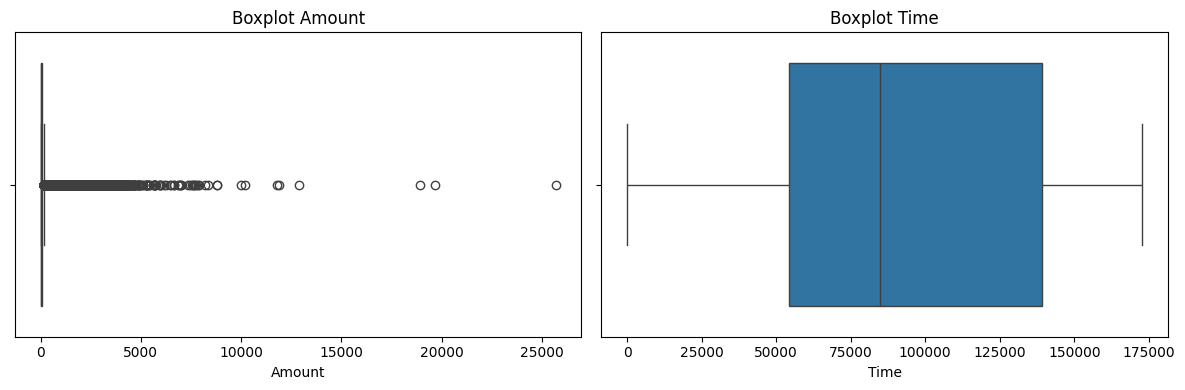

Outliers (IQR k=1.5) em Amount: 31685
Outliers (IQR k=1.5) em Time: 0


In [5]:
# Boxplots para inspeção
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.boxplot(x=df["Amount"], ax=axes[0])
axes[0].set_title("Boxplot Amount")
sns.boxplot(x=df["Time"], ax=axes[1])
axes[1].set_title("Boxplot Time")
plt.tight_layout()
plt.show()

# Identificação por IQR para Amount e Time (apenas marcação; tratamento será via escala robusta)
def iqr_outlier_bounds(series, k=1.5):
    q1, q3 = np.percentile(series, [25, 75])
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return lower, upper

for col in ["Amount", "Time"]:
    lower, upper = iqr_outlier_bounds(df[col])
    out_count = ((df[col] < lower) | (df[col] > upper)).sum()
    print(f"Outliers (IQR k=1.5) em {col}: {out_count}")

# Em vez de remover, optamos por tratamento robusto:
# - Transformação log1p em Amount (mitigar cauda longa)
# - Escalonamento RobustScaler para Amount e StandardScaler para Time
df["Amount_log"] = np.log1p(df["Amount"])


5) Normalização e/ou padronização

In [6]:
# As variáveis V1..V28 resultam de PCA (já tendem a estar escaladas),
# mas escalonar Time e Amount_log ajuda alguns modelos.
feature_cols = [c for c in df.columns if c not in ["Class", "Amount"]]
time_col = "Time"
amount_log_col = "Amount_log"

# Criar coluna transformada
df["Amount_log"] = np.log1p(df["Amount"])

pca_cols = [c for c in df.columns if c.startswith("V")]

preprocessor = ColumnTransformer(
    transformers=[
        ("time_scaler", StandardScaler(), [time_col]),
        ("amount_scaler", RobustScaler(), [amount_log_col]),
        ("passthrough_pca", "passthrough", pca_cols),
    ],
    remainder="drop"
)

6) Análise e correlação

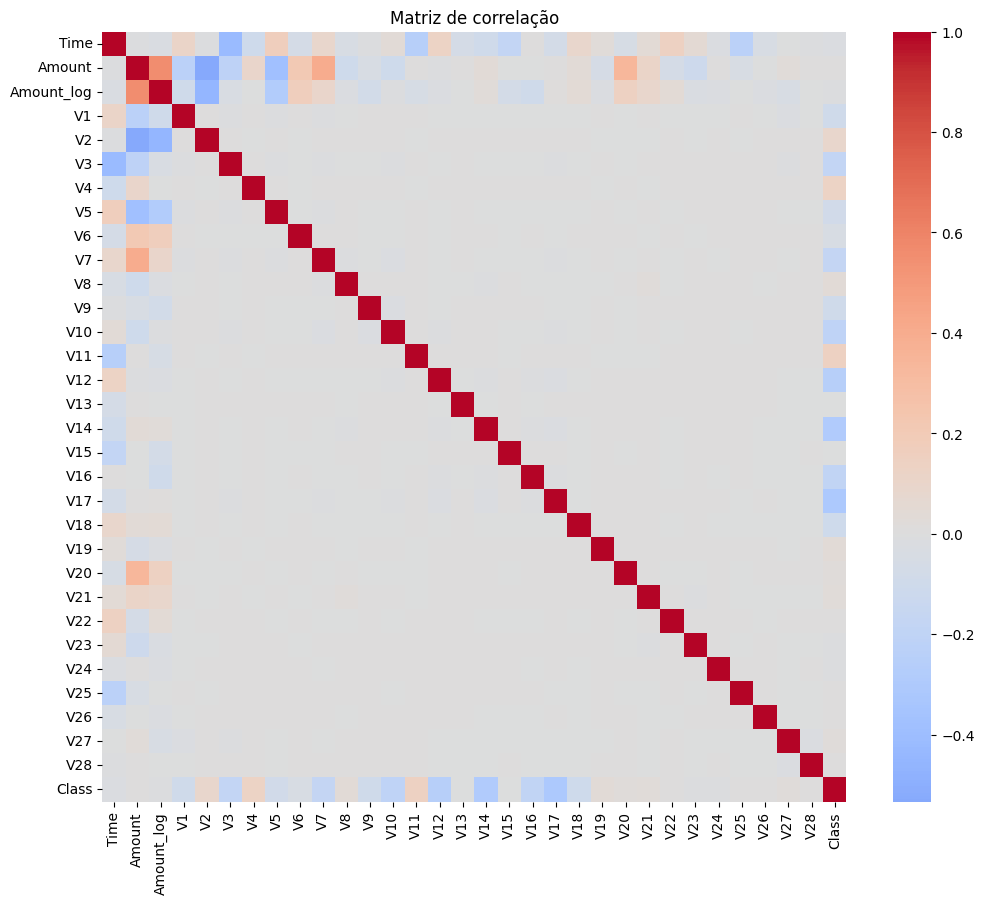

In [7]:
corr = df[["Time", "Amount", "Amount_log"] + pca_cols + ["Class"]].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Matriz de correlação")
plt.show()

7) Balanceamento da classe

In [8]:
X = df[[time_col, amount_log_col] + pca_cols].copy()
y = df["Class"].astype(int)

print("\nDistribuição de classe antes do balanceamento:")
print(y.value_counts(normalize=True).rename("proporção"))

# Usaremos SMOTE dentro de um pipeline de modelagem para evitar vazamento de dados:
# (SMOTE será aplicado apenas no conjunto de treino, após o escalonamento)
# Para demonstrar o pipeline completo, usamos LogisticRegression com class_weight='balanced'
model = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=RANDOM_STATE)

clf = ImbPipeline(steps=[
    ("preprocess", preprocessor),
    ("smote", SMOTE(random_state=RANDOM_STATE, sampling_strategy="auto", k_neighbors=5)),
    ("model", model),
])


Distribuição de classe antes do balanceamento:
Class
0    0.998333
1    0.001667
Name: proporção, dtype: float64


8) Divisão treino-teste estratificada 

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y, #estratificando
    random_state=42
)

print("\nDistribuição de classe no treino (ANTES do SMOTE):")
print(y_train.value_counts(normalize=True).rename("proporção"))
print("\nDistribuição de classe no teste:")
print(y_test.value_counts(normalize=True).rename("proporção"))

 
# Aplicando SMOTE manualmente para visualizar
smote = SMOTE(random_state=42, sampling_strategy="auto", k_neighbors=5)
X_res, y_res = smote.fit_resample(X_train, y_train)

print("\nDistribuição de classe no treino (DEPOIS do SMOTE):")
print(y_res.value_counts(normalize=True).rename("proporção"))


Distribuição de classe no treino (ANTES do SMOTE):
Class
0    0.998335
1    0.001665
Name: proporção, dtype: float64

Distribuição de classe no teste:
Class
0    0.998326
1    0.001674
Name: proporção, dtype: float64

Distribuição de classe no treino (DEPOIS do SMOTE):
Class
0    0.5
1    0.5
Name: proporção, dtype: float64


### Aplicando e comparando usando o modelo LogisticRegression

In [ ]:
# -----------------------------
# Divisão treino–teste
# -----------------------------
X = df.drop(columns=["Class"])  # todas as features sem a coluna alvo
y = df["Class"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# -----------------------------
# Modelo baseline SEM pré-processamento
# -----------------------------
model_raw = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
model_raw.fit(X_train, y_train)
y_pred_raw = model_raw.predict(X_test)

print("\nRelatório de classificação (SEM pré-processamento):")
print(classification_report(y_test, y_pred_raw, digits=4))

# -----------------------------
# Modelo COM pré-processamento (escalonamento + SMOTE)
# -----------------------------
model = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)

clf = ImbPipeline(steps=[
    ("preprocess", preprocessor),
    ("smote", SMOTE(random_state=42, sampling_strategy="auto", k_neighbors=5)),
    ("model", model),
])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("\nRelatório de classificação (COM pré-processamento):")
print(classification_report(y_test, y_pred, digits=4))


c:\Users\mathe\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Relatório de classificação (SEM pré-processamento):
              precision    recall  f1-score   support

           0     0.9998    0.9721    0.9858     56651
           1     0.0500    0.8737    0.0945        95

    accuracy                         0.9720     56746
   macro avg     0.5249    0.9229    0.5402     56746
weighted avg     0.9982    0.9720    0.9843     56746


Relatório de classificação (COM pré-processamento):
              precision    recall  f1-score   support

           0     0.9998    0.9738    0.9866     56651
           1     0.0530    0.8737    0.1000        95

    accuracy                         0.9737     56746
   macro avg     0.5264    0.9238    0.5433     56746
weighted avg     0.9982    0.9737    0.9852     56746



### Aplicando Algoritmos de Agrupamento

1) Preparação dos dados (remover Class)

In [ ]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from minisom import MiniSom

# Remover a coluna alvo
X = df.drop(columns=["Class", "Amount"])  # mantendo o Amount_log
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [13]:
X

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount_log
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,5.014760
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,1.305626
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,5.939276
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,4.824306
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,4.262539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.570980
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,3.249987
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,4.232366
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,2.397895


2a) K-Means

In [19]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
labels_kmeans = kmeans.fit_predict(X_scaled)

2b) DBSCAN

In [20]:
dbscan = DBSCAN(eps=2.0, min_samples=5)
labels_dbscan = dbscan.fit_predict(X_scaled)

2c) SOM

In [21]:
som = MiniSom(x=10, y=10, input_len=X_scaled.shape[1], sigma=1.0, learning_rate=0.5, random_seed=42)
som.train_random(X_scaled, 100)  # 100 iterações de treino

# Para obter clusters, podemos mapear cada instância para seu BMU (Best Matching Unit)
labels_som = np.array([som.winner(x) for x in X_scaled])

## Resultados

In [29]:
# Confirmar os 2 grupos no dataset
print("Clusters KMeans:", np.unique(labels_kmeans))
print("Clusters DBSCAN:", np.unique(labels_dbscan))
print("Clusters SOM:", np.unique(labels_som))

Clusters KMeans: [0 1]
Clusters DBSCAN: [ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178
 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196
 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214
 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232
 233 234 23

In [26]:
# Imprimir os resultados de cada algoritmo
print("K-Means:")
print("Silhouette:", silhouette_score(X_scaled, labels_kmeans))
print("Davies-Bouldin:", davies_bouldin_score(X_scaled, labels_kmeans))
print("Calinski-Harabasz:", calinski_harabasz_score(X_scaled, labels_kmeans))

K-Means:
Silhouette: 0.06498971374549742
Davies-Bouldin: 3.9484315188844556
Calinski-Harabasz: 13795.092635750269


In [27]:
# Imprimir os resultados de cada algoritmo
print("DBSCAN:")
if len(set(labels_dbscan)) > 1:
    print("Silhouette:", silhouette_score(X_scaled, labels_dbscan))
    print("Davies-Bouldin:", davies_bouldin_score(X_scaled, labels_dbscan))
    print("Calinski-Harabasz:", calinski_harabasz_score(X_scaled, labels_dbscan))
else:
    print("DBSCAN não encontrou mais de um cluster válido.")

DBSCAN:
Silhouette: -0.21471823289247022
Davies-Bouldin: 1.5177982611813903
Calinski-Harabasz: 101.03362503786707


In [ ]:
# Imprimir os resultados de cada algoritmo
print("SOM:")
labels_som = [som.winner(x) for x in X_scaled]  # lista de tuplas
# Converter cada tupla em string ou índice único
labels_som = [str(t) for t in labels_som]

print("Clusters SOM:", np.unique(labels_som))

if len(set(labels_som)) > 1:
    print("Silhouette:", silhouette_score(X_scaled, labels_som))

SOM:
Clusters SOM: ['(np.int64(0), np.int64(0))' '(np.int64(0), np.int64(1))'
 '(np.int64(0), np.int64(2))' '(np.int64(0), np.int64(3))'
 '(np.int64(0), np.int64(4))' '(np.int64(0), np.int64(5))'
 '(np.int64(0), np.int64(6))' '(np.int64(0), np.int64(7))'
 '(np.int64(0), np.int64(8))' '(np.int64(0), np.int64(9))'
 '(np.int64(1), np.int64(0))' '(np.int64(1), np.int64(1))'
 '(np.int64(1), np.int64(2))' '(np.int64(1), np.int64(3))'
 '(np.int64(1), np.int64(4))' '(np.int64(1), np.int64(5))'
 '(np.int64(1), np.int64(6))' '(np.int64(1), np.int64(7))'
 '(np.int64(1), np.int64(8))' '(np.int64(1), np.int64(9))'
 '(np.int64(2), np.int64(0))' '(np.int64(2), np.int64(1))'
 '(np.int64(2), np.int64(2))' '(np.int64(2), np.int64(3))'
 '(np.int64(2), np.int64(4))' '(np.int64(2), np.int64(5))'
 '(np.int64(2), np.int64(6))' '(np.int64(2), np.int64(7))'
 '(np.int64(2), np.int64(8))' '(np.int64(2), np.int64(9))'
 '(np.int64(3), np.int64(0))' '(np.int64(3), np.int64(1))'
 '(np.int64(3), np.int64(2))' '(np.in

## Gráficos dos Clusters

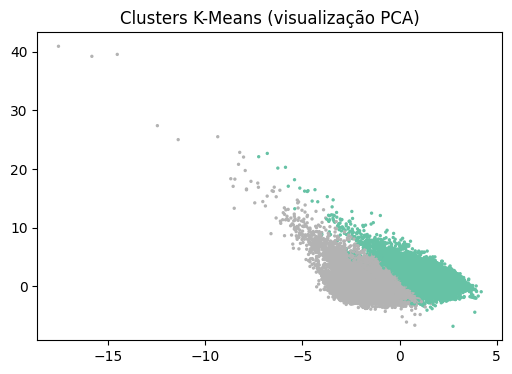

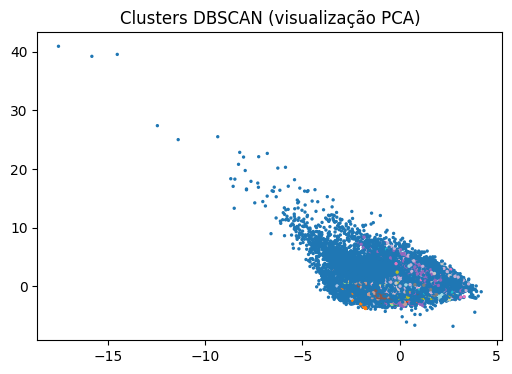

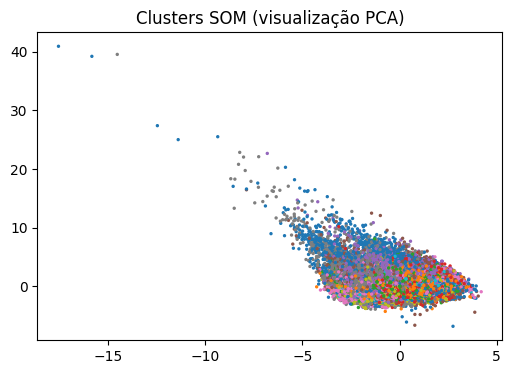

In [32]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduzir para 2 dimensões com PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# K-Means
plt.figure(figsize=(6,4))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_kmeans, cmap="Set2", s=2)
plt.title("Clusters K-Means (visualização PCA)")
plt.show()

# DBSCAN
plt.figure(figsize=(6,4))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_dbscan, cmap="tab20", s=2)
plt.title("Clusters DBSCAN (visualização PCA)")
plt.show()

# SOM
labels_som = [t[0]*10 + t[1] for t in [som.winner(x) for x in X_scaled]]

plt.figure(figsize=(6,4))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_som, cmap="tab10", s=2)
plt.title("Clusters SOM (visualização PCA)")
plt.show()